<a href="https://colab.research.google.com/github/HarshiniR4/Topic-Modelling/blob/main/topicmodelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Topic Modelling and LDA** 

Domain: **Fintech**

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/abcnews-date-text.csv', error_bad_lines=False)
data_text = data[['headline_text']]
data_text['index'] = data_text.index
docs = data_text

In [ ]:
docs.head()

,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4


In [ ]:
len(docs)

1186018

In [ ]:
import re
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk import tokenize
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.models import LdaMulticore
from nltk.stem.porter import *
import numpy as np
from gensim import corpora, models
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from wordcloud import WordCloud
import codecs
import string
import subprocess
import unicodedata

In [ ]:
np.random.seed(2018)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Preprocessing** the data:
1. Tokenising the text
2. Cleaning error
3. Remove stop words
4. Stemming
5. Lemmatisation

In [ ]:
stemmer = SnowballStemmer('english')
def lemmatize(text):
  return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def process_text(text):
  result = []
  for token in simple_preprocess(text):
      if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
          result.append(lemmatize(token))
  return result

In [ ]:
processed_docs = docs['headline_text'].map(process_text)

In [ ]:
num_topics=10

In [ ]:
processed_docs.head()

0     [decid, communiti, broadcast, licenc]
1                        [wit, awar, defam]
2    [call, infrastructur, protect, summit]
3               [staff, aust, strike, rise]
4      [strike, affect, australian, travel]
Name: headline_text, dtype: object

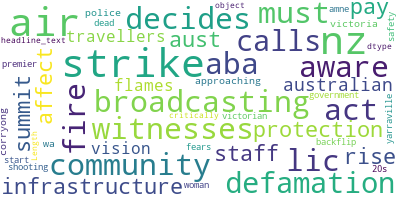

In [ ]:
stopwords1 = stopwords.words()
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords1,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data['headline_text']))
wordcloud.to_image()

**Bag Of Words**

Creating corpus for BoW from documents

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.save('dictionary.dict')

In [ ]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 broadcast
1 communiti
2 decid
3 licenc
4 awar
5 defam
6 wit
7 call
8 infrastructur
9 protect
10 summit


In [ ]:
dictionary.filter_extremes(no_below=12, no_above=0.5, keep_n=100000)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

**TF-TDF**

Using tf-idf on top of the corpus of bow


In [ ]:
tfidf = models.TfidfModel(bow_corpus)

In [ ]:
corpus_tfidf = tfidf[bow_corpus]

**LDA model on BoW**

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
lda_model_bow = Lda(bow_corpus, num_topics=10, id2word=dictionary, passes=2)

In [ ]:
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.033*"news" + 0.026*"woman" + 0.018*"school" + 0.015*"leav" + 0.014*"hospit" + 0.013*"sydney" + 0.013*"tasmanian" + 0.011*"home" + 0.011*"student" + 0.010*"babi"

Topic: 1 
Words: 0.037*"australia" + 0.025*"peopl" + 0.018*"world" + 0.017*"accus" + 0.015*"record" + 0.015*"island" + 0.014*"high" + 0.012*"break" + 0.012*"price" + 0.012*"offic"

Topic: 2 
Words: 0.018*"final" + 0.017*"protest" + 0.016*"street" + 0.014*"australia" + 0.012*"farm" + 0.012*"liber" + 0.012*"meet" + 0.012*"presid" + 0.011*"john" + 0.011*"near"

Topic: 3 
Words: 0.042*"year" + 0.028*"elect" + 0.022*"famili" + 0.020*"melbourn" + 0.019*"crash" + 0.018*"kill" + 0.017*"die" + 0.014*"royal" + 0.013*"australian" + 0.013*"australia"

Topic: 4 
Words: 0.023*"china" + 0.018*"south" + 0.018*"adelaid" + 0.017*"canberra" + 0.017*"victorian" + 0.017*"mallacoota" + 0.016*"north" + 0.015*"perth" + 0.012*"bushfir" + 0.012*"climat"

Topic: 5 
Words: 0.025*"stori" + 0.021*"market" + 0.020*"tasmania" + 0.019*"heal

In [ ]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [ ]:
word_dict=get_lda_topics(lda_model_bow, 10)

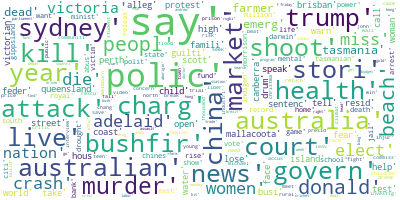

In [ ]:
stopwords1 = stopwords.words()
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords1,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(word_dict.values))
wordcloud.to_image()

**LDA model on TF-IDF**

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [ ]:

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.008*"sport" + 0.007*"australia" + 0.007*"friday" + 0.006*"septemb" + 0.006*"live" + 0.006*"age" + 0.006*"bushfir" + 0.006*"brief" + 0.005*"decemb" + 0.005*"rugbi"
Topic: 1 Word: 0.016*"polic" + 0.012*"murder" + 0.012*"woman" + 0.011*"charg" + 0.010*"kill" + 0.009*"crash" + 0.009*"shoot" + 0.009*"death" + 0.007*"dead" + 0.007*"attack"
Topic: 2 Word: 0.009*"health" + 0.008*"govern" + 0.006*"indigen" + 0.006*"morrison" + 0.005*"mental" + 0.005*"juli" + 0.005*"scott" + 0.005*"school" + 0.004*"fund" + 0.004*"servic"
Topic: 3 Word: 0.010*"elect" + 0.008*"cricket" + 0.007*"david" + 0.006*"histori" + 0.005*"liber" + 0.005*"australia" + 0.005*"state" + 0.005*"quiz" + 0.005*"america" + 0.005*"say"
Topic: 4 Word: 0.009*"market" + 0.008*"monday" + 0.007*"wall" + 0.007*"queensland" + 0.007*"street" + 0.007*"driver" + 0.006*"price" + 0.006*"share" + 0.006*"august" + 0.005*"rise"
Topic: 5 Word: 0.025*"trump" + 0.008*"climat" + 0.008*"child" + 0.008*"turnbul" + 0.008*"tuesday" + 0.007

In [ ]:
unseen_document = 'Why did so many Americans vote for Trump?'
bow_vector = dictionary.doc2bow(process_text(unseen_document))

for index, score in sorted(lda_model_bow[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topics: {}".format(score, lda_model_bow.print_topic(index, 5)))


Score: 0.27500003576278687	 Topics: 0.037*"australia" + 0.025*"peopl" + 0.018*"world" + 0.017*"accus" + 0.015*"record"
Score: 0.2750000059604645	 Topics: 0.036*"australian" + 0.026*"donald" + 0.023*"chang" + 0.018*"resid" + 0.014*"fear"
Score: 0.2750000059604645	 Topics: 0.044*"trump" + 0.022*"live" + 0.018*"court" + 0.017*"alleg" + 0.017*"face"
Score: 0.02500000037252903	 Topics: 0.033*"news" + 0.026*"woman" + 0.018*"school" + 0.015*"leav" + 0.014*"hospit"
Score: 0.02500000037252903	 Topics: 0.018*"final" + 0.017*"protest" + 0.016*"street" + 0.014*"australia" + 0.012*"farm"
Score: 0.02500000037252903	 Topics: 0.042*"year" + 0.028*"elect" + 0.022*"famili" + 0.020*"melbourn" + 0.019*"crash"
Score: 0.02500000037252903	 Topics: 0.023*"china" + 0.018*"south" + 0.018*"adelaid" + 0.017*"canberra" + 0.017*"victorian"
Score: 0.02500000037252903	 Topics: 0.025*"stori" + 0.021*"market" + 0.020*"tasmania" + 0.019*"health" + 0.018*"feder"
Score: 0.02500000037252903	 Topics: 0.048*"polic" + 0.025*"

In [ ]:
vectorizer = CountVectorizer(analyzer='word', max_features=5000)
train_headlines = list()
for value in processed_docs.iloc[0:].values:
  for i in value:
    train_headlines.append(i)

x_counts = vectorizer.fit_transform(train_headlines);

In [ ]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(8, 6))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

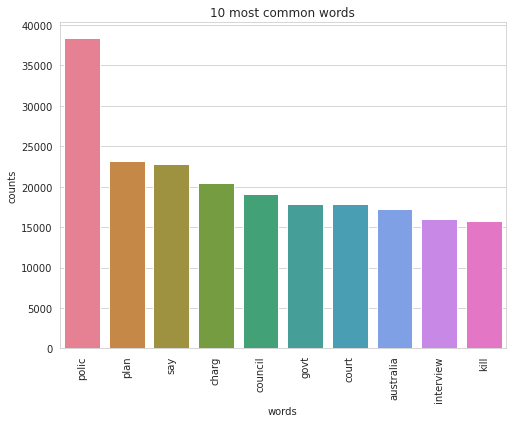

In [ ]:
plot_10_most_common_words(x_counts, vectorizer)

In [ ]:
transformer = TfidfTransformer(smooth_idf=False)
x_tfidf = transformer.fit_transform(x_counts)

In [ ]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
model = NMF(n_components=10, init='nndsvd')
model.fit(xtfidf_norm)


NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
def get_nmf_topics(model, n_top_words):
    feat_names = vectorizer.get_feature_names()
    word_dict = {};
    for i in range(num_topics):
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    return pd.DataFrame(word_dict);

In [ ]:
word_dict_nmf=get_nmf_topics(model, 20)

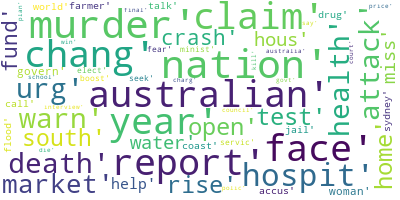

In [ ]:
stopwords1 = stopwords.words()
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords1,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(word_dict_nmf.values))
wordcloud.to_image()

In [ ]:
bigram = gensim.models.Phrases(processed_docs, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[processed_docs], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_bow, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.164392 -0.139629       1        1  11.433052
8     -0.264664 -0.195585       2        1  11.298200
6      0.120551 -0.074134       3        1  10.397070
3     -0.211965  0.083161       4        1  10.254011
4      0.204982 -0.075638       5        1   9.813208
9      0.135959 -0.073352       6        1   9.595216
7      0.069082  0.153008       7        1   9.583229
0     -0.153124 -0.156731       8        1   9.440330
1      0.025706  0.276127       9        1   9.318202
2     -0.090921  0.202775      10        1   8.867482, topic_info=            Term          Freq         Total Category  logprob  loglift
236        polic  29020.000000  29020.000000  Default  30.0000  30.0000
6840       trump  22669.000000  22669.000000  Default  29.0000  29.0000
1107        year  23133.000000  23133.000000  Default  28.0000  28.0000
16    australian  27227.000000  27227.000000  Default  27.0000  27.0000
37     australia  32239.000000  32239.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
343      protest   8014.311251  10660.661465  Topic10  -4.0844   2.1374
224         hear   4146.369819   5643.465706  Topic10  -4.7434   2.1145
390         race   3493.283725   4645.329493  Topic10  -4.9148   2.1378
37     australia   6731.978458  32239.015532  Topic10  -4.2588   0.8565
344         warn   2810.530079   9388.374795  Topic10  -5.1323   1.2167

[380 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
322       1  0.999938  aborigin
1899      2  0.999945      abus
211       9  0.999884     accus
513       9  0.999815    action
969       5  0.999915   adelaid
...     ...       ...       ...
422       7  0.360440     world
422       9  0.639521     world
1107      4  0.999945      year
356       7  0.999778     young
383       1  0.999802   zealand

[398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 7, 4, 5, 10, 8, 1, 2, 3])

**TEXT EXTRACTION FROM PDF AND PEROMORING ANALYSIS ON TEXT**

In [ ]:
import PyPDF2  
pdf = open('fintech_sample_pdf.pdf', 'rb')  
pdfReader = PyPDF2.PdfFileReader(pdf)  
print("Pages in pdf: {}".format(pdfReader.numPages))
pg_text=""
for i in range(pdfReader.numPages):
  pageObj = pdfReader.getPage(i)
  pg_text+="".join(pageObj.extractText())

ModuleNotFoundError: ignored

In [ ]:
txt_file = open("/content/fintech_converted.txt", "w")
txt_file.write(pg_text)
txt_file.close()

In [ ]:
df = pd.DataFrame(pg_text) 

In [ ]:
processed_pg=[]
for i in range(len(df)):
  processed_pg.append(df[i].map(process_text))

In [ ]:
processed_df = pd.DataFrame(processed_pg)

In [ ]:
processed_df

0    [barkhordari, nourollah, mashayekhi, mashayekh...
1                                                   []
2                                                   []
3                                                   []
4                                               [wang]
Name: 4, dtype: object

In [ ]:
import spacy 
  
nlp = spacy.load('en_core_web_sm') 

In [ ]:
pip install pdfminer

     |████████████████████████████████| 4.2MB 5.7MB/s 
     |████████████████████████████████| 13.7MB 311kB/s 
  Created wheel for pdfminer: filename=pdfminer-20191125-cp36-none-any.whl size=6140063 sha256=b397979a01c8cf2ee1f58a390b3db3cdfb5da71087e43c737c95a3d95ba177f4
  Stored in directory: /root/.cache/pip/wheels/e1/00/af/720a55d74ba3615bb4709a3ded6dd71dc5370a586a0ff6f326
Successfully built pdfminer


In [ ]:
import pdfminer

In [ ]:
import os
import csv
import sys 

directory_with_files_of_interest = "/content/drive/MyDrive/"
file_to_convert_to_txt = "fintech_sample_pdf.pdf"
converted_filename = "fintech_converted.txt"
#scroll over so you don't miss cut off text here
os.system("python pdfminer-20140328/tools/pdf2txt.py -o %s %s/%s" %(converted_filename, directory_with_files_of_interest, file_to_convert_to_txt))

#take a look at the contents
file = open("%s" %(converted_filename), "rt")
for line in file:
     print(line)

FileNotFoundError: ignored

In [ ]:
file = open("%s/%s" %(directory_with_files_of_interest, converted_filename), "rt")
for line in file:
     print(line)
     